In [1]:
from datetime import datetime, timedelta

from typing import Dict

import numpy as np 
import pandas as pd

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import requests


In [2]:
def get_prices_binance(symbol: str, 
                       interval: str, 
                       start_time: datetime.timestamp, 
                       end_time: datetime.timestamp, 
                       limit: int = 1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    return data

In [3]:
def create_df(data: Dict) -> pd.DataFrame:
    df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                 'Taker buy quote asset volume', 'Ignore'])
    df['Date_time'] = pd.to_datetime(df['Close time'], unit='ms')
    df['Date'] = df['Date_time'].dt.date
    df['Time'] = df['Date_time'].dt.time
    df['Close'] = df['Close'].astype(float)
    df['Volume_in_asset'] = df['Volume'].astype(float)
    df['Volume_in_USDT'] = (df['Volume_in_asset'] * df['Close']) / 1000000 
    
    return df[['Date', 'Time', 'Close', 'Volume_in_asset', 'Volume_in_USDT']]

In [22]:
def find_best_distribution(returns, distributions):
    best_distribution = None
    best_params = None
    best_sse = np.inf

    for distribution in distributions:
        dist = getattr(stats, distribution)
        params = dist.fit(returns)
        fitted_data = dist(*params).pdf(returns)
        sse = np.sum((fitted_data - returns) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def plot_distribution(returns, best_distribution, best_params):
    plt.hist(returns, bins=30, density=True, alpha=0.6, color='g', label='Histogram of Returns')
    x = np.linspace(min(returns), max(returns), 1000)
    pdf = getattr(stats, best_distribution)(*best_params).pdf(x)
    plt.plot(x, pdf, 'k-', linewidth=2, label=f'Best Fit {best_distribution} Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

def perform_goodness_of_fit_tests(returns, best_distribution, best_params):
    best_fitted_dist = getattr(stats, best_distribution)(*best_params)
    random_samples = best_fitted_dist.rvs(size=len(returns))

    ks_test_result = stats.kstest(returns, best_distribution, args=best_params)
    mw_test_result = stats.mannwhitneyu(returns, random_samples)

    return ks_test_result, mw_test_result

In [23]:
distributions = [
    "norm",        # Normal distribution
    "t",           # Student's t-distribution
    "gamma",       # Gamma distribution
    "lognorm",     # Log-normal distribution
    "beta",        # Beta distribution
    "laplace",     # Laplace (Double Exponential) distribution
    "cauchy",      # Cauchy distribution
    "logistic",    # Logistic distribution
    "chi2",        # Chi-Square distribution
    "fatiguelife", # Fatigue life (Birnbaum-Saunders) distribution
]

In [24]:
interval = '1d'
ticker  = 'ETHUSDT'

get_date = lambda delta: int((datetime.now() - timedelta(days=delta)).timestamp() * 1000)

dt1 = get_date(1)
dt2 = get_date(365*3+1)

data = get_prices_binance(ticker, interval, dt2, dt1)
df = create_df(data)

In [25]:
returns = np.log(df['Close'].pct_change().dropna() + 1)
returns = np.array(returns)

/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


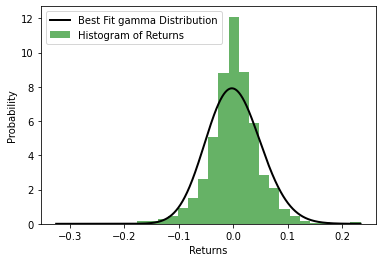

Best distribution: gamma
Best parameters: (152.7577668051336, -0.623045862954352, 0.004089840124215578)
Kolmogorov-Smirnov test p-value: 6.706915020957295e-07
Kolmogorov-Smirnov test rejects the null hypothesis.
Mann-Whitney U test p-value: 0.14297237445137828
Mann-Whitney U test does not reject the null hypothesis.


In [26]:
best_distribution, best_params = find_best_distribution(returns, distributions)

plot_distribution(returns, best_distribution, best_params)

ks_test_result, mw_test_result = perform_goodness_of_fit_tests(returns, best_distribution, best_params)

print(f"Best distribution: {best_distribution}")
print(f"Best parameters: {best_params}")

alpha = 0.01

print(f"Kolmogorov-Smirnov test p-value: {ks_test_result.pvalue}")
if ks_test_result.pvalue < alpha:
    print("Kolmogorov-Smirnov test rejects the null hypothesis.")
else:
    print("Kolmogorov-Smirnov test does not reject the null hypothesis.")

print(f"Mann-Whitney U test p-value: {mw_test_result.pvalue}")
if mw_test_result.pvalue < alpha:
    print("Mann-Whitney U test rejects the null hypothesis.")
else:
    print("Mann-Whitney U test does not reject the null hypothesis.")

In [28]:
x = np.linspace(min(returns), max(returns), 1000)
pdf = getattr(stats, best_distribution)(*best_params).pdf(x)

1788.3349638229338

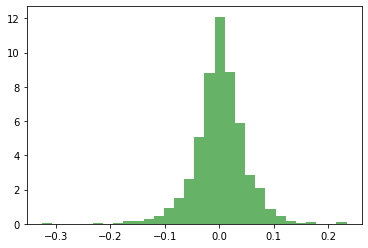

In [34]:
y =plt.hist(returns, bins=30, density=True, alpha=0.6, color='g', label='Histogram of Returns')

In [36]:
y[0]

array([ 0.0537584 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0537584 ,  0.        ,  0.0537584 ,  0.1612752 ,  0.1612752 ,
        0.268792  ,  0.4300672 ,  0.91389279,  1.50523518,  2.63416157,
        5.05328954,  8.8163775 , 12.09563986,  8.8701359 ,  5.91342393,
        2.84919517,  2.09657758,  0.86013439,  0.48382559,  0.1612752 ,
        0.0537584 ,  0.1075168 ,  0.        ,  0.        ,  0.1075168 ])

In [37]:
y[1]

array([-0.32486075, -0.30624038, -0.28762002, -0.26899965, -0.25037929,
       -0.23175892, -0.21313856, -0.19451819, -0.17589783, -0.15727746,
       -0.1386571 , -0.12003674, -0.10141637, -0.08279601, -0.06417564,
       -0.04555528, -0.02693491, -0.00831455,  0.01030582,  0.02892618,
        0.04754655,  0.06616691,  0.08478728,  0.10340764,  0.12202801,
        0.14064837,  0.15926874,  0.1778891 ,  0.19650946,  0.21512983,
        0.23375019])

In [38]:
returns

array([-1.28467033e-02,  2.23481201e-03, -3.75826007e-02, -8.63059925e-02,
        1.12480553e-02, -7.06834679e-02,  8.44174903e-02,  8.41791842e-03,
        5.66702185e-03,  1.00364908e-02, -9.92347732e-03,  1.63366155e-02,
        1.11169784e-04, -1.95886602e-02, -2.07610005e-02,  1.01221901e-03,
        1.83875040e-02,  3.54113035e-03, -3.70738197e-02,  2.43284161e-03,
        2.70618510e-02,  3.93083834e-02,  1.49552778e-02,  9.77608903e-03,
        3.24742275e-02, -1.42533844e-02, -6.18642806e-03, -2.77656757e-03,
       -3.26750817e-02,  7.68584634e-03,  2.62330330e-02,  3.14229012e-03,
       -2.88324645e-02,  5.76256395e-02,  5.86970398e-02, -1.18335949e-02,
        7.37902892e-03, -1.53548249e-02, -3.34207812e-02,  2.74650730e-02,
       -3.84546168e-02, -2.83739357e-03, -1.20580448e-02,  1.03258607e-02,
        2.60763310e-02, -3.50174936e-02,  1.26088063e-02,  3.69742384e-02,
        3.46722882e-02,  8.99528816e-02, -4.64667484e-02,  4.29290995e-02,
       -2.22127492e-02,  

/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


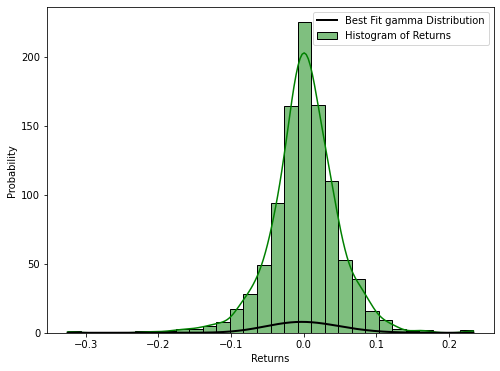

In [40]:
def plot_distribution_with_sns(returns, best_distribution, best_params, num_bins=30):
    plt.figure(figsize=(8, 6))

    # Calculate the histogram with specified number of bins
    counts, bin_edges = np.histogram(returns, bins=num_bins, density=True)

    # Plot the histogram using seaborn
    sns.histplot(returns, bins=bin_edges, kde=True, color='g', label='Histogram of Returns')

    x = np.linspace(min(returns), max(returns), 1000)
    pdf = getattr(stats, best_distribution)(*best_params).pdf(x)

    # Plot the best-fit distribution
    sns.lineplot(x, pdf, color='k', linewidth=2, label=f'Best Fit {best_distribution} Distribution')

    plt.xlabel('Returns')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Example usage:
plot_distribution_with_sns(returns, best_distribution, best_params)